Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 16-July-2025

In [4]:
import pandas as pd
import numpy as np
from scipy.ndimage import uniform_filter1d
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# Set parameters and load data
data_dir = r'Z:/Data/Roadrunner/'
dataset = 'arena_empty_cschrimson_sinusoidal.csv'

sampling_rate = 20 # Hz
filter_size = 0.3 # s

color_ctrl = [0,0,0]
color_rr = [0/255, 174/255, 239/255]

# Load data
# Note: Positive angular velocity corresponds to counterclockwise turning
df = pd.read_csv(data_dir+dataset) 
df

,animal_id,animal_sex,trial,frame,time,intensity,x,y,speed,n_stimulus,n_inter_stimulus_interval
0,1,female,1,1,0.05,0.000474,89.1,45.3,0.0,0.0,0.0
1,1,female,1,2,0.10,-0.000184,89.1,45.3,0.0,0.0,0.0
2,1,female,1,3,0.15,-0.000184,89.1,45.3,0.0,0.0,0.0
3,1,female,1,4,0.20,-0.000184,89.1,45.3,0.0,0.0,0.0
4,1,female,1,5,0.25,0.000145,89.1,45.3,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
167995,16,female,5,2096,104.80,-0.000184,51.5,30.6,0.0,0.0,50.0
167996,16,female,5,2097,2096.05,-0.000184,51.5,30.6,0.0,0.0,50.0
167997,16,female,5,2098,2096.10,-0.000184,51.5,30.6,0.0,0.0,50.0
167998,16,female,5,2099,2096.15,-0.000184,51.5,30.6,0.0,0.0,50.0


In [9]:
#df.set.unique().tolist()

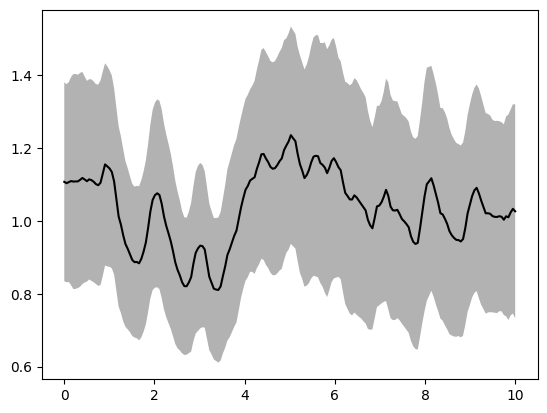

In [22]:
# Plot mean time course for a specific intensity
parameter_name = "speed" 
experiments = [1,2] 
intensity = 9
animal_sex = ['female','male']
stimulus_duration = 5 # s
pre_duration = 0 # s
post_duration = 5 # s

# Initialize variables
if 'sinusoidal' in dataset:
    df_sub = df[(df.animal_sex.isin(animal_sex))]
else:
    df_sub = df[(df.intensity==intensity) & (df.set.isin(experiments))]

animal_ids = df_sub.animal_id.unique().tolist()
n_animals = len(animal_ids)
mean_parameters = np.zeros(((pre_duration+stimulus_duration+post_duration)*sampling_rate, len(animal_ids)))
mean_intensities = np.zeros(((pre_duration+stimulus_duration+post_duration)*sampling_rate, len(animal_ids)))

# Loop over animals
for animal_id_index, animal_id in enumerate(animal_ids):
    n_stimulus = df_sub.n_stimulus[df_sub.animal_id==animal_id].to_numpy()
    intensity = df_sub.intensity[df_sub.animal_id==animal_id].to_numpy()
    parameter = df_sub[parameter_name][df_sub.animal_id==animal_id].to_numpy()   

    # Flip angular velocity for set 'right'
    if parameter_name=='angular_velocity' and df_sub.set[df_sub.animal_id==animal_id].unique().item()=='right': 
        parameter = parameter*-1
    
    stimulus_onset_indices = np.argwhere(np.diff(n_stimulus)>0)+1
    
    mean_parameter = np.zeros(((pre_duration+stimulus_duration+post_duration)*sampling_rate, len(stimulus_onset_indices)))
    mean_intensity = np.zeros(((pre_duration+stimulus_duration+post_duration)*sampling_rate, len(stimulus_onset_indices))) 

    # Loop over stimulus presentations
    for index, _ in enumerate(stimulus_onset_indices):
        onset = stimulus_onset_indices[index][0]-pre_duration*sampling_rate
        offset = stimulus_onset_indices[index][0]+(stimulus_duration+post_duration)*sampling_rate
        
        mean_parameter[:,index] = uniform_filter1d(parameter[onset:offset], size=int(filter_size*sampling_rate))
        mean_intensity[:,index] = intensity[onset:offset]
        
    mean_parameters[:,animal_id_index] = np.nanmean(mean_parameter,axis=1) 
    mean_intensities[:,animal_id_index] = np.nanmean(mean_intensity,axis=1) 

# Plot mean time course
time = time = np.linspace(-pre_duration, stimulus_duration+post_duration, num=(pre_duration+stimulus_duration+post_duration)*sampling_rate)
mean = np.mean(mean_parameters,axis=1)
sem = np.std(mean_parameters,axis=1)/np.sqrt(np.size(mean_parameters,1))

if 'rr' in dataset:
    color = color_rr
else:
    color = color_ctrl
    
plt.plot(time, mean, color=color)
plt.fill_between(time, mean-sem, mean+sem, color=color, alpha=0.3, edgecolor='none')
#plt.ylim([-200,200])
#plt.savefig(r'C:\Users\Chris\Desktop\figure.eps')
plt.show()

In [23]:
# Get sample size
animal_ids = df_sub.animal_id.unique().tolist()
print('N = ' + str(len(animal_ids)))

for animal_id in animal_ids:
    print('Animal ' + str(animal_id) + ': ' + str(len(df_sub.trial[df_sub["animal_id"]==animal_id].unique().tolist()) * 10))

N = 16
Animal 1: 50
Animal 2: 50
Animal 3: 50
Animal 4: 50
Animal 5: 50
Animal 6: 50
Animal 7: 50
Animal 8: 50
Animal 9: 50
Animal 10: 50
Animal 11: 50
Animal 12: 50
Animal 13: 50
Animal 14: 50
Animal 15: 50
Animal 16: 50


In [6]:
def compute_mean_of_activation(df, parameter_name, filter_size):

    # Initialize variables 
    intensities = df.intensity.unique().tolist() 
    n_animals = int(len(df.animal_id.unique().tolist()) / len(intensities))
    
    mean_parameters = np.empty((n_animals,len(intensities)))
    mean_parameters[:] = np.nan
    
    # Loop over intensities
    for intensity_index, intensity in enumerate(intensities):
        animal_ids = df.animal_id[df.intensity==intensity].unique().tolist()
    
        # Loop over animals
        for animal_id_index, animal_id in enumerate(animal_ids):
            parameter = df[parameter_name][(df.animal_id==animal_id) & (df.n_stimulus!=0)].to_numpy()
            parameter = uniform_filter1d(parameter, size=int(filter_size))
    
            # Flip angular velocity for set 'right'
            if parameter_name=='angular_velocity' and df.set[df.animal_id==animal_id].unique().item()=='right': 
                parameter = parameter*-1
            
            parameter = np.mean(parameter)
    
            mean_parameters[animal_id_index,intensity_index] = parameter
        
    return mean_parameters

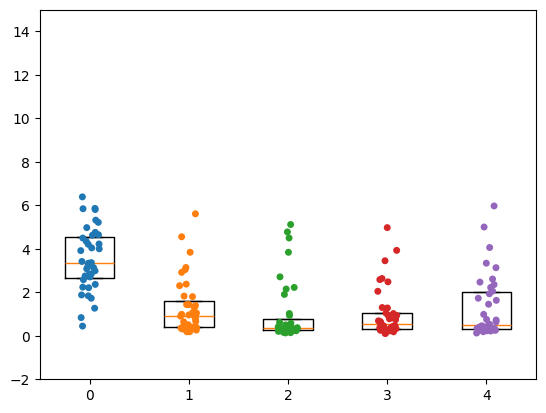

In [7]:
# Plot mean of activation per animal and intensity 
parameter_name = "speed"
experiments = [1,2] # set 1: decreasing; set 2: increasing

# Compute means
df_sub = df[df.set.isin(experiments)] 
means = compute_mean_of_activation(df_sub, parameter_name, filter_size*sampling_rate)

# Plot means    
plt.boxplot(means, positions=[0,1,2,3,4], showfliers=False, whis=0)
sns.stripplot(means)
plt.ylim([-2,15])
#plt.ylim([-200,200])
#plt.savefig(r'C:\Users\Chris\Desktop\figure.eps')
plt.show()

In [8]:
means

array([[3.08232556, 0.98690429, 2.15116565, 2.04729905, 2.35595991],
       [2.57836997, 0.32076574, 0.19958488, 1.02338546, 5.97328215],
       [4.49640126, 0.66502347, 0.23281183, 0.30990959, 2.05386956],
       [4.22262167, 0.95803568, 0.40703806, 0.68808836, 4.06067603],
       [4.64942579, 1.43474764, 0.16159911, 0.60817332, 2.22271513],
       [4.97526153, 0.90412635, 0.24607459, 0.45743955, 0.4757711 ],
       [2.23866559, 0.38472839, 0.3781332 , 0.658063  , 0.48676707],
       [2.75179934, 0.3589316 , 0.61489152, 2.58464998, 0.98556012],
       [5.21839441, 1.04723237, 0.33320352, 0.38448226, 0.34567915],
       [2.21160228, 3.14208179, 0.20409237, 0.28100667, 0.40573185],
       [5.85958979, 1.82569465, 0.33099193, 0.27074487, 1.7285397 ],
       [1.87861017, 3.84147652, 3.84177997, 0.28328517, 0.29837816],
       [3.36494093, 1.30449262, 0.3362389 , 0.18406784, 0.53391238],
       [4.20894872, 2.30546266, 0.29176174, 0.36644632, 0.39186253],
       [4.00033649, 1.80117966, 0.

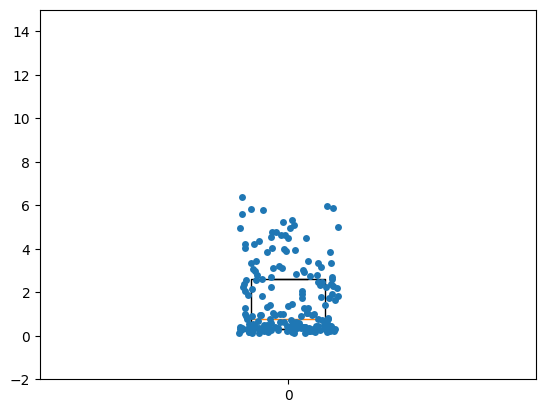

In [31]:
# Plot mean of activation of all intensities
parameter_name = "speed"
experiments = [1,2] # set 1: decreasing; set 2: increasing

# Compute means
df_sub = df[df.set.isin(experiments)] 
means = compute_mean_of_activation(df_sub, parameter_name, filter_size*sampling_rate)
means = means.flatten()

# Plot means    
plt.boxplot(means, positions=[0], showfliers=False, whis=0)
sns.stripplot(means)
plt.ylim([-2,15])
#plt.ylim([-200,200])
#plt.savefig(r'C:\Users\Chris\Desktop\figure.eps')
plt.show()

In [38]:
np.size(means,axis=0)

18

In [24]:
# Statistics

# # Shapiro Wilk test for normality
#_, p_value = stats.shapiro(means[:,0])
#print(p_value)

# # Levenes test for equal variance
# _, p_value = stats.levene(means[:,0], means[:,1], means[:,2], means[:,3], means[:,4])
# print(p_value)

# One-way ANOVA
# F(number of groups - 1, number of observations - number of groups)
f_statistic, p_value = stats.f_oneway(means[:,0], means[:,1], means[:,2], means[:,3], means[:,4])
print(f_statistic)
print(p_value)

# Tukey's HSD test
res = stats.tukey_hsd(means[:,0], means[:,1], means[:,2], means[:,3], means[:,4])
print(res)

51.29747000797804
5.202523646170806e-29
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -2.755     0.000    -3.953    -1.557
 (0 - 2)     -4.262     0.000    -5.460    -3.064
 (0 - 3)     -4.967     0.000    -6.165    -3.770
 (0 - 4)     -5.463     0.000    -6.661    -4.266
 (1 - 0)      2.755     0.000     1.557     3.953
 (1 - 2)     -1.507     0.006    -2.705    -0.309
 (1 - 3)     -2.212     0.000    -3.410    -1.015
 (1 - 4)     -2.708     0.000    -3.906    -1.511
 (2 - 0)      4.262     0.000     3.064     5.460
 (2 - 1)      1.507     0.006     0.309     2.705
 (2 - 3)     -0.705     0.485    -1.903     0.492
 (2 - 4)     -1.201     0.049    -2.399    -0.004
 (3 - 0)      4.967     0.000     3.770     6.165
 (3 - 1)      2.212     0.000     1.015     3.410
 (3 - 2)      0.705     0.485    -0.492     1.903
 (3 - 4)     -0.496     0.785    -1.694     0.702
 (4 - 0)      5.463     0.000     4.266   

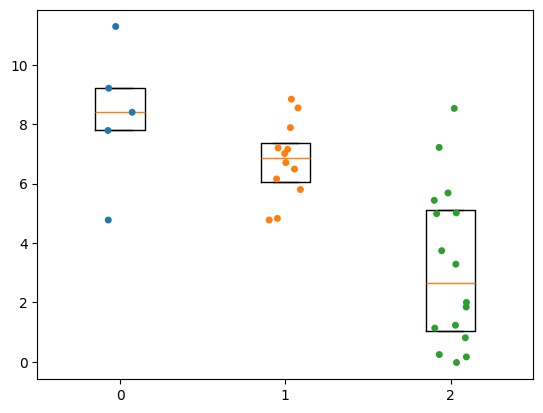

In [381]:
# Plot mean of activation per animal and intensity for SPARC data
parameter_name = "forward_velocity"

# Compute means
experiments = ["bilateral"] 
df_sub = df[df.set.isin(experiments)] 
means_bi = compute_mean_of_activation(df_sub, parameter_name, filter_size*sampling_rate)

experiments = ["left","right"] 
df_sub = df[df.set.isin(experiments)] 
means_uni = compute_mean_of_activation(df_sub, parameter_name, filter_size*sampling_rate)

experiments = ["empty"] 
df_sub = df[df.set.isin(experiments)] 
means_none = compute_mean_of_activation(df_sub, parameter_name, filter_size*sampling_rate)

# Plot means    
plt.boxplot([means_bi[:,0],means_uni[:,0],means_none[:,0]], positions=[0,1,2], showfliers=False, whis=0)
sns.stripplot([means_bi[:,0],means_uni[:,0],means_none[:,0]])
#plt.ylim([-2,15])
#plt.ylim([-200,200])
#plt.savefig(r'C:\Users\Chris\Desktop\figure.eps')
plt.show()

In [382]:
len(mean_parameters)

16

In [383]:
# Statistics

# Mann-Whitney U test for non-normally distributed (nonparametric) data
stats.mannwhitneyu(means_uni[:,0],means_none[:,0])

MannwhitneyuResult(statistic=np.float64(165.0), pvalue=np.float64(0.0014725845118836066))

In [216]:
np.size(mean_parameters,axis=0)

38

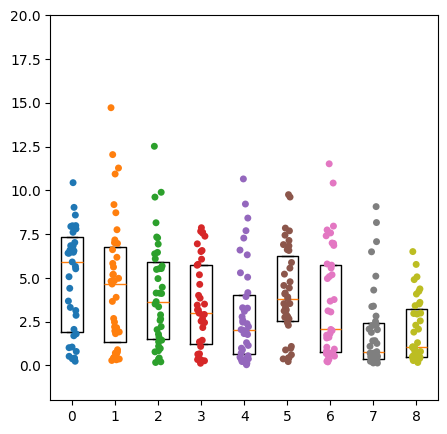

In [277]:
# Plot mean of time course per animal and repetition for a specific intensity
parameter_name = 'speed'
experiments = [1,2] 
intensity = 1
stimulus_duration = 10 # s

# Initialize variables
df_sub = df[(df.intensity==intensity) & (df.set.isin(experiments))]
animal_ids = df_sub.animal_id.unique().tolist()
n_animals = len(animal_ids)
n_stimulus_presentations = len(df_sub.n_stimulus[df_sub.n_stimulus!=0].unique().tolist())
mean_parameters = np.zeros((n_animals, n_stimulus_presentations))

# Loop over animals
for animal_id_index, animal_id in enumerate(animal_ids):
    n_stimulus = df_sub.n_stimulus[df_sub.animal_id==animal_id].to_numpy()
    parameter = df_sub[parameter_name][df_sub.animal_id==animal_id].to_numpy()
    stimulus_onset_indices = np.argwhere(np.diff(n_stimulus)>0)+1

    # Loop over stimulus presentations
    for index, _ in enumerate(stimulus_onset_indices):
        onset = stimulus_onset_indices[index][0]
        offset = stimulus_onset_indices[index][0]+stimulus_duration*sampling_rate
        mean_parameter = uniform_filter1d(parameter[onset:offset], size=int(filter_size*sampling_rate))
        mean_parameter = np.mean(mean_parameter)
        mean_parameters[animal_id_index,index] = mean_parameter

# Plot speed over stimulus repetitions
fig, ax = plt.subplots(figsize=(5, 5))
if 'rr' in dataset:
    color = color_rr
else:
    color = color_ctrl
    
plt.boxplot(mean_parameters, positions=(range(np.size(mean_parameters,1))), showfliers=False, whis=0)
sns.stripplot(mean_parameters)
ax.set_ylim(-2,20)
plt.savefig(r'C:\Users\Chris\Desktop\figure.eps')
plt.show()

In [29]:
n_animals

39

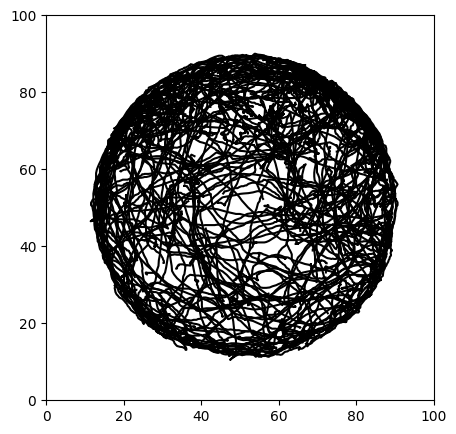

In [21]:
# Plot trajectories for a specific intensity 
# Note: Different experiments can have different absolute x/y values. Plot separately.
intensity = 9
experiments = [2] # [1,2]
subtract_origin = False
stimulus_duration = 10 # s

# Initialize variables
df_sub = df[(df.intensity==intensity) & (df.set.isin(experiments))] 
animal_ids = df_sub.animal_id.unique().tolist()
fig, ax = plt.subplots(figsize=(5, 5))

# Loop over animals
for animal_id in animal_ids:
    #animal_id = animal_ids[25]
    x = df_sub["x"][(df_sub.animal_id==animal_id)].to_numpy() 
    y = df_sub["y"][(df_sub.animal_id==animal_id)].to_numpy() 
    n_stimulus = df_sub["n_stimulus"][(df_sub.animal_id==animal_id)].to_numpy() 
    stimulus_onset_indices = np.argwhere(np.diff(n_stimulus)>0)+1
    
    onset = stimulus_onset_indices[0][0]

    # Loop over stimulus presentations
    for index, _ in enumerate(stimulus_onset_indices):
        onset = stimulus_onset_indices[index][0]
        offset = onset+(stimulus_duration)*sampling_rate

        if subtract_origin:
            ax.plot(x[onset:offset]-x[onset], y[onset:offset]-y[onset], color=[0,0,0])
        else:
            ax.plot(x[onset:offset], y[onset:offset], color=[0,0,0])

if subtract_origin:
    lim = [-100,100]
else: 
    lim = [0,100]
    
ax.set_xlim(lim)
ax.set_ylim(lim)
plt.savefig(r'C:\Users\Chris\Desktop\figure.eps')
plt.show()